# Project: ij-blocking

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [6]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

In [80]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

echo "===== cleaning up ====="
make clean
echo "===== compiling ====="
make VERSION=ijblocking2

===== cleaning up =====
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
===== compiling =====
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-ijblocking2.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-ijblocking2.o -o stencil2d-ijblocking2.x
cp stencil2d-ijblocking2.x stencil2d.x


In [72]:
output = !srun -n 1 ./stencil2d-ijblocking2.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 --size_i 64 --size_j 64

for hit and miss rates:

In [92]:

%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools

echo "===== cleaning up ====="
make clean
echo "===== compiling ====="
make VERSION=kblocking

pat_build -Drtenv=PAT_RT_PERFCTR=1 -g mpi -u stencil2d-kblocking.x
srun -n 1 ./stencil2d-kblocking.x+pat --nx 128 --ny 128 --nz 64 --num_iter 1024

===== cleaning up =====
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
===== compiling =====
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-kblocking.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-kblocking.o -o stencil2d-kblocking.x
cp stencil2d-kblocking.x stencil2d.x


FATAL: The file 'stencil2d-kblocking.x+pat' already exists.
CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.1442863E+01], \
] )


Experiment data directory written:
/users/class172/HPC4WC_project_ijblocking/stencil2d-kblocking.x+pat+9735-2747t


In [93]:
%%bash
pat_report -o report.txt stencil2d-kblocking.x+pat+*

Skipping file because of suffix:  stencil2d-kblocking.x+pat+9522-2747t/index.ap2
Skipping file because of suffix:  stencil2d-kblocking.x+pat+9522-2747t/ap2-files
Skipping file because of suffix:  stencil2d-kblocking.x+pat+9522-2747t/xf-files
Processing step 10 of 10


In [42]:
#speed kblocking
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.8684521E+01], \
] )


In [5]:
#speed jblocking
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.8793299E+01], \
] )


In [31]:
#speed ijblocking small
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.4582935E+01], \
] )


In [25]:
#speed ijblocking inline
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.4753916E+01], \
] )


In [39]:
#speed ijblocking compile variables
print(output.nlstr)
exec(output.nlstr)

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.4534093E+01], \
] )


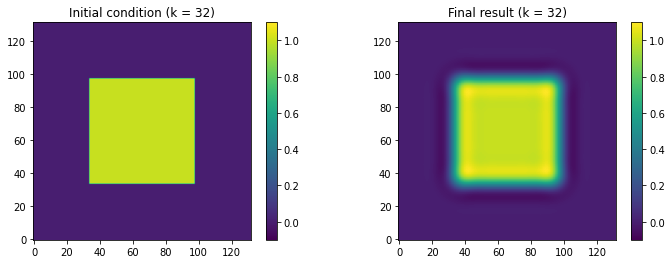

In [10]:
validate_results()

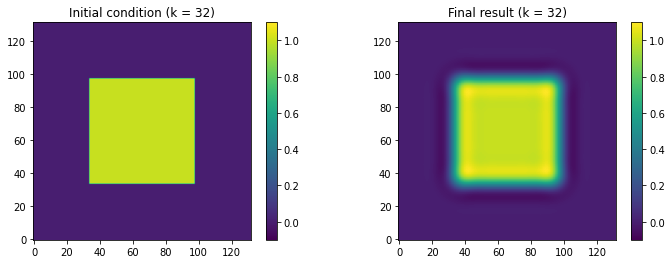

In [6]:
validate_results()

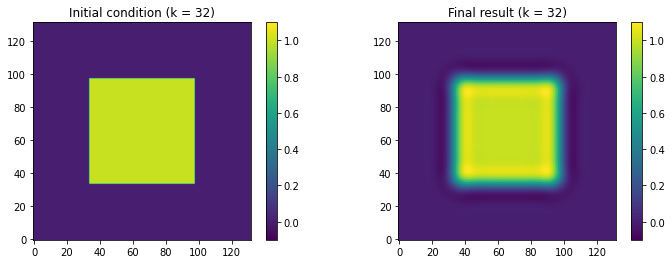

In [38]:
validate_results()

In [60]:
np.arange(64, 6400, 64)

array([  64,  128,  192,  256,  320,  384,  448,  512,  576,  640,  704,
        768,  832,  896,  960, 1024, 1088, 1152, 1216, 1280, 1344, 1408,
       1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112,
       2176, 2240, 2304, 2368, 2432, 2496, 2560, 2624, 2688, 2752, 2816,
       2880, 2944, 3008, 3072, 3136, 3200, 3264, 3328, 3392, 3456, 3520,
       3584, 3648, 3712, 3776, 3840, 3904, 3968, 4032, 4096, 4160, 4224,
       4288, 4352, 4416, 4480, 4544, 4608, 4672, 4736, 4800, 4864, 4928,
       4992, 5056, 5120, 5184, 5248, 5312, 5376, 5440, 5504, 5568, 5632,
       5696, 5760, 5824, 5888, 5952, 6016, 6080, 6144, 6208, 6272, 6336])